In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.1 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask as raster_mask
from rasterio.features import rasterize
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

In [3]:

# Lấy các đường dẫn band
band_files = {
    'B2': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B02_10m.jp2",
    'B3': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B03_10m.jp2",
    'B4': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B04_10m.jp2",
    'B8': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B08_10m.jp2",
    'B11': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B11_20m.jp2",
    'B12': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B12_20m.jp2"
}

In [4]:
# Đọc vùng ROI
roi = gpd.read_file("/content/drive/MyDrive/Project_2/ROI/ROI.geojson")
roi.set_crs(epsg=4326, inplace=True)
roi = roi.to_crs("EPSG:32648")  # CRS của ảnh Sentinel

# Clip và chuẩn hóa bands
clipped_bands = {}
ref_shape = (1186, 1200)
transform = None

In [5]:
for b, path in band_files.items():
    with rasterio.open(path) as src:
        clipped, out_transform = raster_mask(src, roi.geometry, crop=True)
        band_data = clipped[0]

        # Resample nếu band có độ phân giải 20m
        if src.res[0] == 20:
            scale = 2  # 20m → 10m
            band_data = zoom(band_data, scale, order=1)

        # Cắt theo kích thước chuẩn
        band_data = band_data[:ref_shape[0], :ref_shape[1]]

        clipped_bands[b] = band_data

        # Lưu transform từ band đầu tiên
        if transform is None:
            transform = out_transform

In [6]:
# Tính chỉ số NDVI
ndvi = (clipped_bands['B8'] - clipped_bands['B4']) / (clipped_bands['B8'] + clipped_bands['B4'] + 1e-10)

# Stack bands
band_stack = np.stack([clipped_bands[b] for b in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']], axis=-1)
n_rows, n_cols, n_bands = band_stack.shape
X = band_stack.reshape(-1, n_bands)
ndvi = ndvi[:, :, np.newaxis]  # => shape (rows, cols, 1)

# Gộp lại với band_stack
band_stack_with_ndvi = np.concatenate([band_stack, ndvi], axis=-1)
# Chuyển thành (pixels, features)
X_full = band_stack_with_ndvi.reshape(-1, band_stack_with_ndvi.shape[-1])

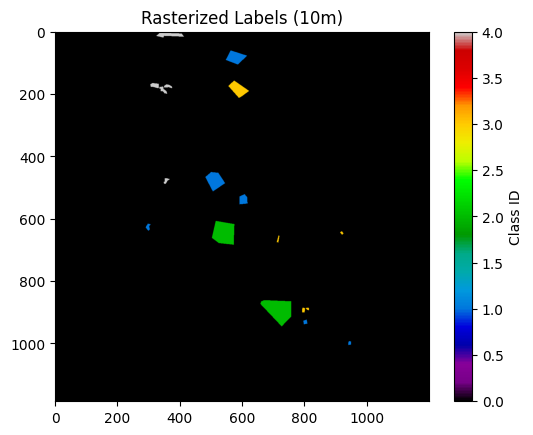

In [7]:
gdf = gpd.read_file('/content/drive/MyDrive/Project_2/Training_data/training_data.shp')
id_to_class = { 1: 'water', 2: 'built_area', 3: 'vegetation', 4: 'others'}
gdf['class'] = gdf['macroclass'].map(id_to_class)
gdf = gdf.to_crs("EPSG:32648")  # Đồng bộ CRS

shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf['macroclass'])]
label_raster = rasterize(
    shapes=shapes,
    out_shape=ref_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Visual kiểm tra raster nhãn
plt.imshow(label_raster, cmap='nipy_spectral')
plt.title("Rasterized Labels (10m)")
plt.colorbar(label="Class ID")
plt.show()

In [8]:
rows, cols = np.where(label_raster > 0)
labels = label_raster[rows, cols]

# Tọa độ không gian cho mỗi điểm raster nhãn
xs, ys = rasterio.transform.xy(transform, rows, cols)
coords = np.column_stack([xs, ys])

In [9]:
features = []
for b in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']:
    band = clipped_bands[b]
    band_values = band[rows, cols]
    features.append(band_values)

# Thêm NDVI vào đặc trưng
features.append(ndvi[rows, cols])

# Tập dữ liệu đầu ra
X = np.column_stack(features)
y = labels

print("X shape:", X.shape)  # (số điểm, 6)
print("y shape:", y.shape)  # (số điểm,)

X shape: (18681, 7)
y shape: (18681,)


In [10]:
import pandas as pd

# Tạo dataframe để quan sát
columns = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI']
df = pd.DataFrame(X, columns=columns)
df['label'] = y

# Hiển thị 5 dòng đầu tiên
print(df.head())


       B2      B3      B4      B8     B11     B12      NDVI  label
0  1393.0  1547.0  1694.0  2246.0  2797.0  2386.0  0.140102      4
1  1386.0  1545.0  1718.0  2282.0  2812.0  2392.0  0.141000      4
2  1426.0  1597.0  1694.0  2306.0  2821.0  2394.0  0.153000      4
3  1459.0  1562.0  1720.0  2322.0  2829.0  2393.0  0.148936      4
4  1421.0  1546.0  1723.0  2269.0  2836.0  2391.0  0.136774      4


In [11]:
from sklearn.model_selection import train_test_split

# Chia 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Số lượng mẫu training:", len(y_train))
print("Số lượng mẫu test:", len(y_test))


Số lượng mẫu training: 14944
Số lượng mẫu test: 3737


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Tạo mô hình Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred = clf.predict(X_test)



# Báo cáo kết quả
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=[ 'water', 'built_area', 'vegetation','others']))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



 Classification Report:
              precision    recall  f1-score   support

       water       1.00      1.00      1.00      1028
  built_area       0.98      0.99      0.99      1915
  vegetation       0.94      0.91      0.93       423
      others       0.97      0.94      0.95       371

    accuracy                           0.98      3737
   macro avg       0.97      0.96      0.97      3737
weighted avg       0.98      0.98      0.98      3737

 Confusion Matrix:
[[1028    0    0    0]
 [   0 1899   13    3]
 [   0   29  386    8]
 [   0   10   12  349]]


In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Dự đoán toàn ảnh (reshape về lại ảnh gốc)
classified_rf = clf.predict(X_full).reshape(ref_shape)


In [14]:
from rasterio.features import geometry_mask

# Tạo mask nhị phân từ ROI (True = ngoài ROI, False = trong ROI)
roi_mask = geometry_mask(
    roi.geometry,
    out_shape=ref_shape,
    transform=transform,
    invert=True
)
masked_classified_rf = np.where(roi_mask, classified_rf, 0)  # 0 sẽ không có màu

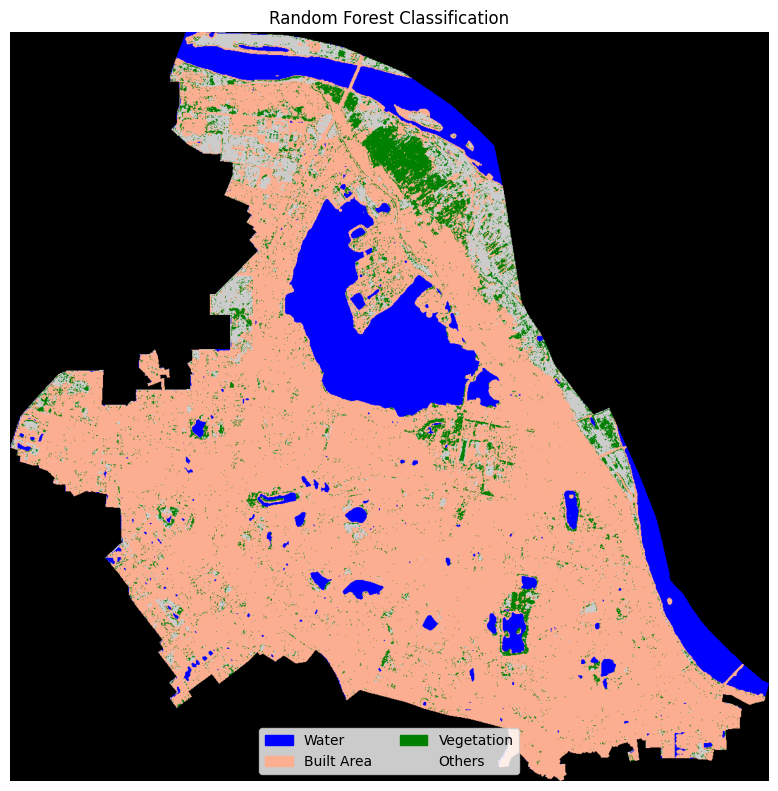

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Cập nhật colormap: 0 là ngoài ROI (ẩn), 1-4 là lớp
cmap = mcolors.ListedColormap(['black', 'blue', '#fcae91', 'green', '#cccccc'])  # 0: ngoài ROI
bounds = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 8))
plt.imshow(masked_classified_rf, cmap=cmap, norm=norm)
plt.title("Random Forest Classification")
plt.axis("off")

# Chú thích: không cần hiển thị '0'
labels = ['Water', 'Built Area', 'Vegetation', 'Others']
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(1, 5)]
plt.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout()
plt.show()



Evaluation using Ground Truth (within ROI):

 Classification Report:
              precision    recall  f1-score   support

       Water       0.99      0.97      0.98    104724
  Built Area       0.94      0.97      0.95    489552
  Vegetation       0.68      0.58      0.63     53367
      Others       0.81      0.70      0.75     67438

    accuracy                           0.92    715081
   macro avg       0.85      0.81      0.83    715081
weighted avg       0.91      0.92      0.91    715081


 Confusion Matrix:
[[101270   2719      0    735]
 [   173 476669   8627   4083]
 [   297  15494  30970   6606]
 [   226  14396   5648  47168]]


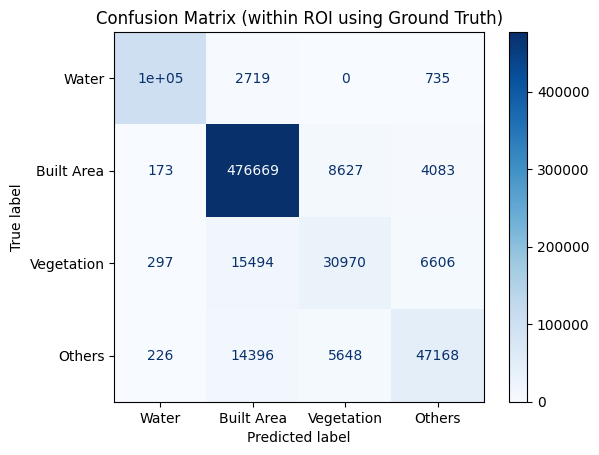


Overall Accuracy on External Ground Truth: 0.9175


In [22]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask as raster_mask
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# %%
# Load the ground truth raster
ground_truth_path = "/content/drive/MyDrive/Project_2/test_data/classified_result.tif"
with rasterio.open(ground_truth_path) as src_gt:
    ground_truth, gt_transform = raster_mask(src_gt, roi.geometry, crop=True)

    # Resample ground truth to match ref_shape if needed
    if ground_truth.shape[1:] != ref_shape:
        scale_factor = (ref_shape[0] / ground_truth.shape[1], ref_shape[1] / ground_truth.shape[2])
        ground_truth = zoom(ground_truth[0], scale_factor, order=0)[np.newaxis, :, :] # Use order=0 for nearest neighbor

    # Remove the extra dimension from the clipped result
    ground_truth = ground_truth[0]


# Ensure the ground truth is an integer type for classification
ground_truth = ground_truth.astype(np.uint8)

# Apply the ROI mask to the ground truth as well
masked_ground_truth = np.where(roi_mask, ground_truth, 0)

# Extract the non-zero pixels (within ROI) for comparison
y_true_roi = masked_ground_truth[masked_ground_truth > 0]
y_pred_roi = masked_classified_rf[masked_classified_rf > 0]

# Evaluate the model using the ground truth within the ROI
print("\nEvaluation using Ground Truth (within ROI):")
print("\n Classification Report:")
print(classification_report(y_true_roi, y_pred_roi, target_names=['Water', 'Built Area', 'Vegetation', 'Others']))

# Calculate confusion matrix for ground truth
cm_roi = confusion_matrix(y_true_roi, y_pred_roi)

print("\n Confusion Matrix:")
print(cm_roi)

# Visualize confusion matrix for ground truth
display_labels = ['Water', 'Built Area', 'Vegetation', 'Others']
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay here
disp_roi = ConfusionMatrixDisplay(confusion_matrix=cm_roi, display_labels=display_labels)
disp_roi.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (within ROI using Ground Truth)")
plt.show()

# Optional: Calculate overall accuracy
overall_accuracy = np.sum(np.diag(cm_roi)) / np.sum(cm_roi)
print(f"\nOverall Accuracy on External Ground Truth: {overall_accuracy:.4f}")

Training SVM model...
SVM model training complete.

SVM Evaluation on Test Set:

 Classification Report:
              precision    recall  f1-score   support

       Water       1.00      1.00      1.00      1028
  Built Area       0.99      0.98      0.98      1915
  Vegetation       0.90      0.84      0.87       423
      Others       0.85      0.97      0.91       371

    accuracy                           0.97      3737
   macro avg       0.94      0.95      0.94      3737
weighted avg       0.97      0.97      0.97      3737

 Confusion Matrix:
[[1028    0    0    0]
 [   0 1869   33   13]
 [   0   18  355   50]
 [   0    7    5  359]]
Predicting on full image with SVM...
Prediction complete.


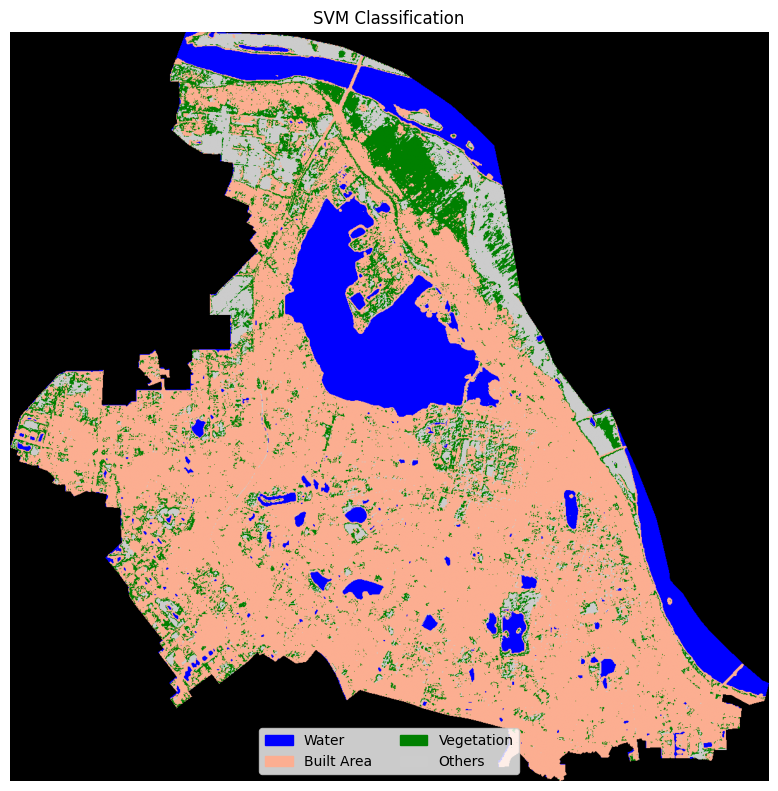


SVM Evaluation using Ground Truth (within ROI):

 Classification Report:
              precision    recall  f1-score   support

       Water       0.99      0.98      0.99    104724
  Built Area       0.97      0.91      0.94    489552
  Vegetation       0.49      0.74      0.59     53367
      Others       0.74      0.78      0.76     67438

    accuracy                           0.90    715081
   macro avg       0.80      0.85      0.82    715081
weighted avg       0.92      0.90      0.91    715081


 Confusion Matrix:
[[103085   1639      0      0]
 [   501 447214  31789  10048]
 [    78   5501  39281   8507]
 [   326   5198   9043  52871]]


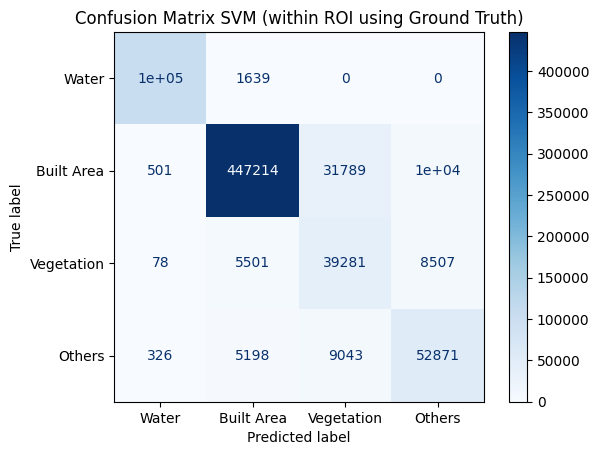

In [18]:
# %%
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import zoom

# Tạo mô hình SVM
clf_svm = svm.SVC(kernel='rbf', random_state=42) # Thường dùng RBF kernel

# Train mô hình
# Sử dụng tập dữ liệu training đã chuẩn bị ở trên (X_train, y_train)
print("Training SVM model...")
clf_svm.fit(X_train, y_train)
print("SVM model training complete.")

# Dự đoán trên tập test để đánh giá sơ bộ
y_pred_svm_test = clf_svm.predict(X_test)
print("\nSVM Evaluation on Test Set:")
print("\n Classification Report:")
print(classification_report(y_test, y_pred_svm_test, target_names=['Water', 'Built Area', 'Vegetation', 'Others']))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm_test))

# %%
# Dự đoán toàn ảnh bằng mô hình SVM
print("Predicting on full image with SVM...")
classified_svm = clf_svm.predict(X_full).reshape(ref_shape)
print("Prediction complete.")

masked_classified_svm = np.where(roi_mask, classified_svm, 0)

cmap = mcolors.ListedColormap(['black', 'blue', '#fcae91', 'green', '#cccccc'])  # 0: ngoài ROI
bounds = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 8))
plt.imshow(masked_classified_svm, cmap=cmap, norm=norm)
plt.title("SVM Classification")
plt.axis("off")

# Chú thích
labels = ['Water', 'Built Area', 'Vegetation', 'Others']
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(1, 5)]
plt.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout()
plt.show()

# %%
# Đánh giá mô hình SVM

y_pred_svm_roi = masked_classified_svm[masked_classified_svm > 0]

print("\nSVM Evaluation using Ground Truth (within ROI):")
print("\n Classification Report:")
print(classification_report(y_true_roi, y_pred_svm_roi, target_names=['Water', 'Built Area', 'Vegetation', 'Others']))

# Tính confusion matrix cho ground truth và dự đoán SVM
cm_svm_roi = confusion_matrix(y_true_roi, y_pred_svm_roi)

print("\n Confusion Matrix:")
print(cm_svm_roi)

# Visualize confusion matrix cho ground truth và dự đoán SVM
display_labels = ['Water', 'Built Area', 'Vegetation', 'Others']
disp_svm_roi = ConfusionMatrixDisplay(confusion_matrix=cm_svm_roi, display_labels=display_labels)
disp_svm_roi.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix SVM (within ROI using Ground Truth)")
plt.show()

In [23]:
# Optional: Calculate overall accuracy
overall_accuracy = np.sum(np.diag(cm_svm_roi)) / np.sum(cm_svm_roi)
print(f"\nOverall Accuracy on External Ground Truth: {overall_accuracy:.4f}")


Overall Accuracy on External Ground Truth: 0.8984
